# Explore the effect of overlap size in slicing embeddings for scenarios having different network-feature correlation

## Imports and setup

In [1]:
import time
import random
import os
from collections import defaultdict
import warnings
import functools
import pickle

import numpy as np
import scipy as sp
import scipy.stats
import sklearn.preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import pandas as pd
import networkx as nx
import dask
import distributed

import keras
from keras import backend as K
import tensorflow as tf
from tensorflow.python import debug as tf_debug
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback as TQDMCallback
from tqdm import tqdm_notebook as tqdm

from progressbar import ProgressBar
from IPython.display import SVG, HTML, display

from nw2vec import ae
from nw2vec import utils
from nw2vec import codecs
from nw2vec import layers
from nw2vec import viz
from nw2vec import batching
from nw2vec import generative
import settings

Using TensorFlow backend.


The `distributed.Client()` connects to the Dask scheduler, which manages the compute cluster. You submit compute tasks through the client (see below).

In [2]:
client = distributed.Client('127.0.0.1:8786')
client

Client Scheduler: tcp://127.0.0.1:8786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 47 Cores: 818 Memory: 7.63 TB


In [3]:
N_ALPHAS = 10
N_MODEL_SAMPLES = 20
N_CLUSTERINGS = 2
N_NODES = 1000
N_CLUSTERS = 100
OVERWRITE_RESULTS = False
COLORS_PATH = os.path.join(settings.BEHAVIOUR_PATH, 'colors')
RESULTS_PATH = (COLORS_PATH
                + '/S2_S3-ov_noov-n_nodes={n_nodes}-n_clusters={n_clusters}'
                + '-n_alphas={n_alphas}-n_models={n_models}-n_clusterings={n_clusterings}'
                + '-{data_name}.pkl')

## Creating the scenarios

In [4]:
α_range = np.linspace(start=0, stop=1, num=N_ALPHAS, endpoint=True)
π_gap_range = np.linspace(start=.075, stop=.12, num=N_CLUSTERINGS, endpoint=True)

def scenario_from_aid_cid(aid, cid, n_nodes=N_NODES, n_clusters=N_CLUSTERS):
    α = α_range[aid]
    ρ = np.ones(n_clusters) / n_clusters
    π_gap = π_gap_range[cid]
    π = ((.13 + π_gap) * np.diag(np.ones(n_clusters))
         + (.13 - π_gap) * (np.ones((n_clusters, n_clusters)) - np.diag(np.ones(n_clusters))))
    Y, A, labels = generative.colors(n_nodes, ρ, π, α)
    g = nx.from_numpy_array(A)
    features = labels + np.random.normal(scale=.1, size=labels.shape)
    return g, Y, scipy.sparse.csr_matrix(A), labels, features

## Drawing the predictions

Functions to visualise the output of the models.

In [5]:
def plot_ξ_kde(q_pred_ξ_sample, ix_iy, communities, palette, ax):
    """Make a KDE plot of sampled embeddings.
    
    Parameters
    ----------
    q_pred_ξ_sample : 2D array, size (n, d)
        The sampled embeddings to plot. `n` is the number of nodes, `d` is the number of embedding dimensions.
    ix_iy : (int, int)
        Dimensions indexing into `q_pred_ξ_sample`, defining which two dimensions to use for the 2D kde.
    communities : 1D array, length n
        The latent community each node belongs to.
    palette : seaborn palette
        Maps values from `communities` to a color.
    ax : matplotlib Axes
        Axes to plot on.
    
    """
    
    ix, iy = ix_iy
    
    for c in sorted(set(communities)):
        idx = communities == c
        x = q_pred_ξ_sample[idx, :, ix].flatten()
        y = q_pred_ξ_sample[idx, :, iy].flatten()
        sb.kdeplot(x, y, cmap=sb.light_palette(palette[c], as_cmap=True),
                   shade=True, shade_lowest=False, ax=ax)
    ax.set_title(r'$\xi_{{{ix}}} \sim \xi_{{{iy}}}$ density'.format(ix=ix, iy=iy))

def plot_ξ_μ(q_pred_μ, ix_iy, communities, palette, ax):
    """Plot the μ parameters of embeddings.
    
    Parameters
    ----------
    q_pred_μ : 2D array, size (n, d)
        The μ parameters in embeddings. `n` is the number of nodes, `d` is the number of embedding dimensions.
    ix_iy : (int, int)
        Dimensions indexing into `q_pred_μ`, defining which two dimensions to use for the 2D plot.
    communities : 1D array, length n
        The latent community each node belongs to.
    palette : seaborn palette
        Maps values from `communities` to a color.
    ax : matplotlib Axes
        Axes to plot on.
    
    """
    
    ix, iy = ix_iy
    
    ax.scatter(q_pred_μ[:, ix], q_pred_μ[:, iy], s=250, c=palette[communities])
    for i, (x, y) in enumerate(q_pred_μ[:, [ix, iy]]):
        ax.text(x, y, str(i), ha='center', va='center', color='white')
    ax.set_title(r'$\mu_{{{ix}}} \sim \mu_{{{iy}}}$'.format(ix=ix, iy=iy))

In [6]:
def plot_ξ_distribution(q_model, q_codecs, scenario):
    """Plot the distribution of embeddings.
    
    Currently this just creates embeddings using the provided model and scenario,
    then delegates to plot_ξ_kde().
    
    Parameter
    ---------
    q_model : nw2vec.ae.Model
        VAE encoder which produces parameters for embedding sampling.
    q_codecs : list of strings
        List of codec names to interpret the outputs of `q_model`. Currently always a single item in the list.
    scenario : tuple
        Tuple of (networkx undirected graph,
                  one-hot latent communities of nodes (Y in the color model),
                  adjacency matrix (symmetric, zeros on the diagonal),
                  node labels)
    
    """
    
    _, Y, adj, labels, _ = scenario
    assert len(q_codecs) == 1
    q_codec = q_codecs[0]
    
    n_communities = Y.shape[1]
    palette = np.concatenate([np.array(sb.color_palette(n_colors=n_communities)),
                              .5 * np.ones((n_communities, 1))],
                             axis=1)
    communities = np.where(Y)[1]

    q_pred = q_model.predict_fullbatch(adj=adj, features=labels)
    q_pred_ξ_sample = K.eval(codecs.get_nocache(q_codec, q_pred).stochastic_value(100))
    dim_ξ = q_pred_ξ_sample.shape[-1]
    assert dim_ξ >= 2
    q_pred_μ = q_pred[:, :dim_ξ]
    
    fig, axes = plt.subplots(dim_ξ - 1, dim_ξ - 1, figsize=(4 * (dim_ξ - 1), 4 * (dim_ξ - 1)), sharex=True, sharey=True)

    for ix in range(dim_ξ - 1):
        for iy in range(ix):
            axes[ix, iy].set_visible(False)
        for iy in range(ix + 1, dim_ξ):
            ax = axes[ix, iy - 1]
            
            # KDE plot
            plot_ξ_kde(q_pred_ξ_sample, (ix, iy), communities, palette, ax)
            
            ## Inset μ plot
            #inset = inset_axes(ax, width="40%", height="40%", loc=4)
            #inset.tick_params(labelleft=False, labelbottom=False)
            #plot_ξ_μ(q_pred_μ, (ix, iy), communities, palette, inset)
            #
            ## Box representing the μ plots in the KDE plots
            #ax.hlines(inset.get_ylim(), *inset.get_xlim(), colors='lightgrey')
            #ax.vlines(inset.get_xlim(), *inset.get_ylim(), colors='lightgrey')

In [7]:
def plot_predictions(model, scenario):
    """Make image plots of the input and ouput of `model` on STBM scenario `scenario`.
    
    Parameters
    ----------
    model : nw2vec.ae.Model
        Full VAE model.
    scenario : tuple
        Tuple of (networkx undirected graph,
                  one-hot STBM latent communities of nodes (Y in the STBM model),
                  adjacency matrix (symmetric, zeros on the diagonal),
                  node STBM labels)
    
    """
    
    g, _, adj, labels, features = scenario
    n_nodes = adj.shape[0]
    q_pred, adj_pred, v_pred = model.predict_fullbatch(adj=adj, features=features)
    adj_pred_mean = scipy.special.expit(adj_pred).mean(axis=1)[0]
    v_pred_mean = utils.softmax(v_pred).mean(axis=1)

    # Embeddings
    fig, ax = plt.subplots(figsize=(4, 4 * n_nodes / 25))
    im = ax.imshow(q_pred)
    ax.set_title('Embeddings')
    plt.colorbar(im, ax=ax)

    # Adjacency matrix
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

    im1 = ax1.imshow(nx.adjacency_matrix(g).toarray())
    ax1.set_title('Real adj')
    plt.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(adj_pred_mean)
    im2.set_norm(im1.norm)
    ax2.set_title('Predicted adj')
    plt.colorbar(im2, ax=ax2)
    
    im3 = ax3.imshow(np.random.binomial(1, adj_pred_mean))
    im3.set_norm(im1.norm)
    ax3.set_title('Sampled predicted adj')
    plt.colorbar(im3, ax=ax3)

    # Features
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4 * n_nodes / 25))
    
    im1 = ax1.imshow(labels)
    ax1.set_title('Real labels')
    plt.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(features)
    ax2.set_title('Features (=noisy labels)')
    plt.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(v_pred_mean)
    im3.set_norm(im1.norm)
    ax3.set_title('Predicted labels')
    plt.colorbar(im3, ax=ax3)

## Show a few STBM scenarios

/home/slerique/anaconda3/envs/base36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


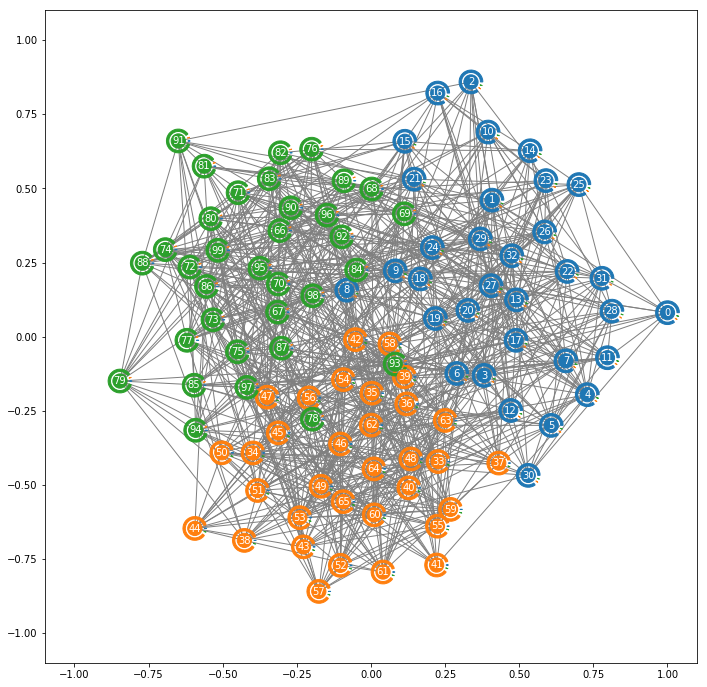

In [8]:
g, _, _, labels, _ = scenario_from_aid_cid(N_ALPHAS - 1, 0, n_nodes=100, n_clusters=3)
viz.draw_network(g, labels=labels);

/home/slerique/anaconda3/envs/base36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


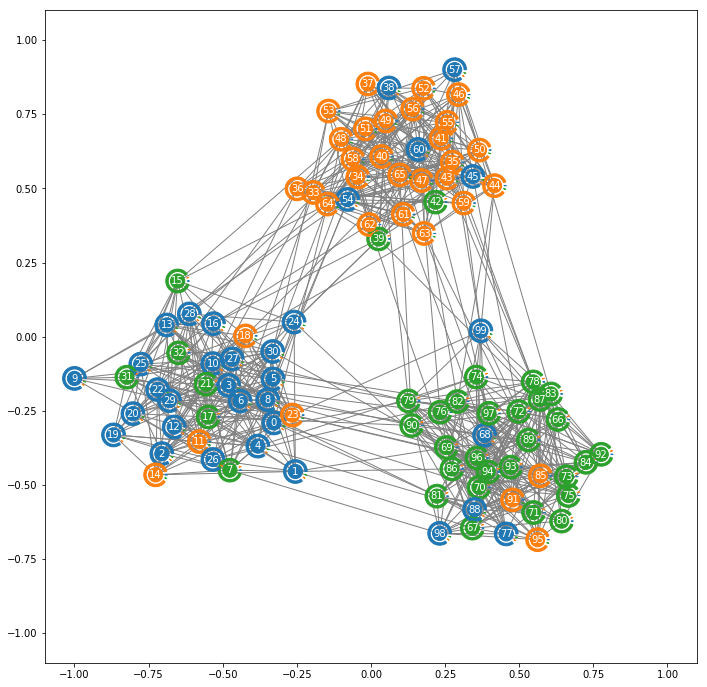

In [9]:
g, _, _, labels, _ = scenario_from_aid_cid(N_ALPHAS // 2, 1, n_nodes=100, n_clusters=3)
viz.draw_network(g, labels=labels);

## Build the VAEs

The rest of the notebook generates VAE models for the different scenarios and different overlaps. This section defines the model-generating function.

In [10]:
# Define the last VAE Parameters
n_ξ_samples = 5  # Number of embeddings sampled at the embedding layer.

def get_loss_weights(n_nodes, dims, q_overlap):
    dim_data, _, dim_ξ_adj, dim_ξ_v = dims
    return {
        # embedding-gaussian divergence scales with number of embedding dimensions,
        # but we also don't want it to overpower the other losses, hence the 1e-2
        'q_mulogS_flat': 1000 * 1e-3 * 1.0 / (dim_ξ_adj - q_overlap + dim_ξ_v),  
        # Adj loss scales with the number of nodes
        'p_adj': 1000 * 1.0 / (n_nodes * np.log(2)),
        # Feature loss scales with the average number of sampled words
        'p_v': 1000 * 1.0 / np.log(dim_data),
    }

def make_vae(n_nodes, dims, q_overlap, p_ξ_slices):
    """Build a VAE with features of dimension `dims`,
    and an overlap size of `q_overlap` between adj and feature embeddings,
    and p_ξ_slices distributing embedding outputs to adj/feature tasks.
    
    Returns
    -------
    q_model : nw2vec.ae.Model
        The encoder model.
    q_codecs : list of strings
        The list of codec names (corresponding to subclasses of nw2vec.codecs.Codec)
        used to interpret the output of `q_model`. Currently this list has always a single item.
    vae : nw2vec.ae.Model
        The full VAE, which includes `q_model`.
    vae_codecs : list of strings
        The list of codec names used to interpret the output of `vae`. The output of `vae` is made of
        the output of `q_model` (so that the first codec name her is always the single codec in `q_codecs`),
        the adjacency reconstruction, and the feature reconstruction.
    
    In the original model, the adj and feature outputs of `vae` would be parameters to distributions
    from which you sample to create a prediction. For the adjacency, they would be numbers between 0 and 1
    (parameters to a Bernoulli distribution for each value in the matrix). The same goes for binary features.
    For non-binary features, we use a Gaussian distribution for feature prediction, so the output for features
    would be the μ values and values of the diagonal of log(Σ) (just like the parametrisation of the embeddings).
    But! The last operation on these layers would be a sigmoid, and the loss we compute downstream
    is a cross-entropy loss, and the combination of these two is not numerically stable (it easily vanishes to 0).
    
    So instead, we push the sigmoid operation into the loss computation (implemented in the codec object,
    where sigmoid and cross-entropy are combined into a numerically stable operation), such that what
    the `vae` outputs for the adj and feature predictions is the values that should go into a sigmoid.
    (This is why some codecs are named 'Sigmoid*'.)
    
    Long story short: if you want to plot predictions, you must:
    1) put the `vae` output values for adj and features into a sigmoid
    2) sample from those values according to what the parameters represent
       (i.e. Bernoulli or parametrised Gaussian).
    
    The plot_predictions() function above does that for you.
    
    """
    
    dim_data, dim_l1, dim_ξ_adj, dim_ξ_v = dims
    
    # Build the encoder model
    q_model, q_codecs = ae.build_q(
        dims,
        # Size of the overlap between the separated adj and feature layers
        # which are combined (with overlap) to construct the embedding
        overlap=q_overlap,
        # Function used to generate fullbatches,
        # used behind the scenes by Model.predict_fullbatch() and Model.fit_fullbatches()
        fullbatcher=batching.fullbatches,
        # Function used to generate minibatches,
        # used behind the scenes by Model.predict_minibatches() and Model.fit_minibatches()
        minibatcher=batching.pq_batches)
    
    # Build a function which, given an input (which would be the embeddings, i.e. the output of the
    # encoder model), will produce the output of the decoder.
    p_builder = ae.build_p_builder(
        dims,
        # The input features are not binary, but between 0 and 1 summing to 1,
        # so we model them as Multinomial variables.
        # The output of the model for the features is therefore passed to the nw2vec.codecs.SoftmaxMultinomial
        # codec, which knows how to compute the loss values.
        feature_codec='SoftmaxMultinomial',
        # Slices used to separate what part of the embeddings is used for adjacency prediction from what part
        # is used for feature prediction. After sampling of embedding values (using the parameters output by
        # the encoder), the first item in this list defines the input to adjacency decoding, and the second
        # item defines the input to feature decoding. In this case they overlap with `overlap` dimensions.
        embedding_slices=p_ξ_slices,
        # Whether or not to use an intermediate layer in decoding.
        with_l1=True,
        # If `with_l1=True`, this defines whether the adjacency flow and the feature flow share the same weights
        # for their intermediate decoding layer.
        share_l1=False)
    
    # Build the actual VAE. This takes the encoder, adds a sampling layer, puts that into the decoder,
    # and compiles the resulting model.
    vae, vae_codecs = ae.build_vae(
        # Encoder and decoder parameters used to create the VAE
        (q_model, q_codecs), p_builder,
        # Number of samples to generate at the embedding layer.
        n_ξ_samples,
        # Weights used in computing the total final loss of the model. The three values are applied to
        # 1) the divergence between embeddings and a standard centred Gaussian
        # 2) the ajd reconstruction loss
        # 3) the feature reconstruction loss
        loss_weights=get_loss_weights(n_nodes, dims, q_overlap)
    )
    
    return q_model, q_codecs, vae, vae_codecs

A few notes about the above:
* Decoding seems to be much better with an intermediate dense layer (i.e. `with_l1=True`) before the final dense layer for feature reconstruction and the bilinear layer for adjacency reconstruction
* The weights for this layer should NOT be shared between adj and feature tracks (i.e. `shared_l1=False`), since this would re-create a dependency between the separated parts of the embeddings.

Now show what the model looks like (the parameters given to `make_vae` have no effect on this drawing). Ignore all the *\_mask and *\_adj inputs (wich are placeholders) to get a real view of the architecture.

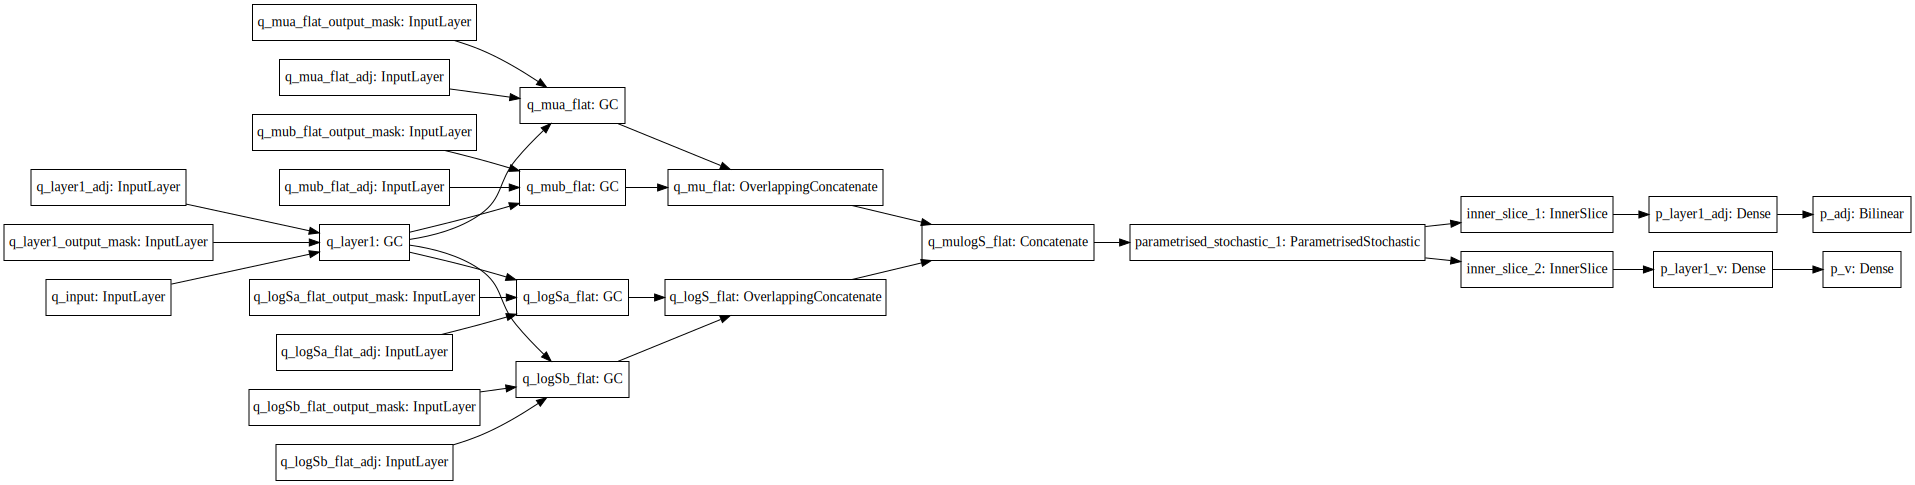

In [11]:
display(SVG(model_to_dot(make_vae(1, (20, 10, 5, 5), 1, None)[2], rankdir='LR').create(prog='dot', format='svg')))

Show what a model looks like before training (it's garbage, but it's nice to see the difference once a model is trained). The plot of the embeddings is the direct output of `q_model`, i.e. it shows the values of μ and the diagonal of log(Σ).

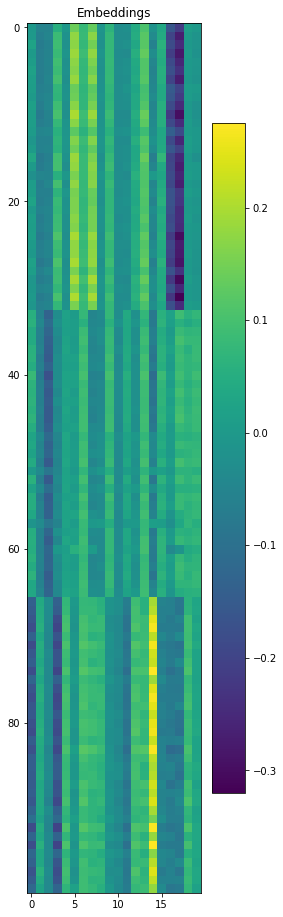

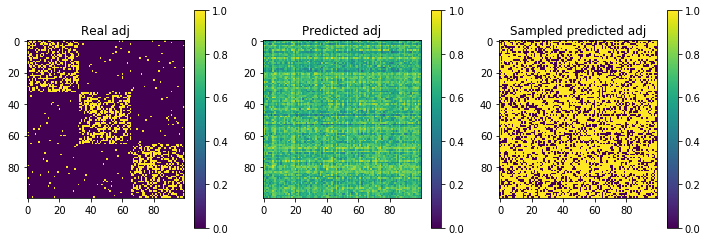

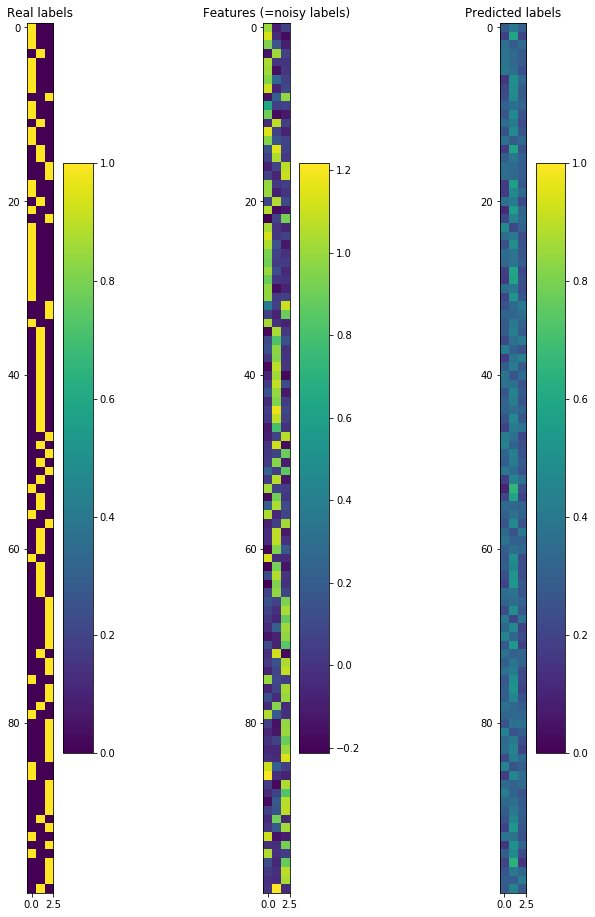

In [12]:
scenario = scenario_from_aid_cid(N_ALPHAS // 2, N_CLUSTERINGS // 2, n_nodes=100, n_clusters=3)
_, _, A, labels, features = scenario
plot_predictions(make_vae(A.shape[0], (labels.shape[1], 20, 5, 5), 0, None)[2], scenario)

## Train

This section generates VAE models with different overlap values for each of the STBM scenarios, and trains them on the distributed Dask cluster. It recovers the history of the losses during training, and the weights of the trained models.

We start by defining the training parameters, and some helpers for the loops further down.

In [48]:
# Maximum number of epochs to train for
n_epochs = 1000

# `target_func` is given to the training function (in fact it's given as a parameter to the fullbatcher,
# through an argument to the training function) and generates the values against which training loss is computed
# for each batch. The complexity of this comes from the fact that for minibatches, the targets change at each
# minibatch (which is why we need a function to create the targets for each minibatch). In the fullbatch case
# the targets are always the same, but the way it's coded is unchanged so we're left with a bit of useless
# complexity here.
# The target values also depend on the STBM scenario used, so here we make a function which
# creates a `target_func` given the STBM node labels.
def make_target_func(labels):
    
    def target_func(batch_adj, required_nodes, final_nodes):
        """Create training targets given the batch's adjacency matrix, the subset of nodes it used as input,
        and the set of nodes for which output values are computed.
        
        In the minibatch setting, `required_nodes` is usually the 2-hop neighbourhood of `final_nodes`.
        In the fullbatch setting all this is constant and equal to the values of the full dataset.
        
        """
        
        # Keras requires a target value for each output of the model trained,
        # so we have one entry per output/loss in the model. Each entry must also have
        # a shape which is compatible with the corresponding output, which is why we have
        # the `utils.expand_dims_tile()` calls: the target value is the same for each of the
        # values generated from the `n_ξ_samples` embeddings.
        return [
            # Keras feeds this to the embedding-gaussian divergence loss function,
            # but we ignore this input in the actual loss function.
            np.zeros(1), # ignored
            # Target value for adjacency reconstruction
            utils.expand_dims_tile(utils.expand_dims_tile(batch_adj + np.eye(batch_adj.shape[0]),
                                                          0, n_ξ_samples),
                                   0, 1),
            # Target value for feature reconstruction
            utils.expand_dims_tile(labels[final_nodes], 1, n_ξ_samples),
        ]
    
    return target_func

def train(model, A, labels, features, with_progress=True):
    """Train `model` using adjacency matrix `A` and `labels` as input.
    
    `with_progress` controls whether or not to show a TQDM progress bar.
    
    Note that the fullbatcher takes care of normalising and centring the input labels,
    so `labels` can be the verbatim values from the STBM scenario.
    
    """
    
    # Show a progressbar if asked to.
    callbacks = []
    if with_progress:
        callbacks.append(TQDMCallback(show_inner=False, leave_outer=False))
    
    # Ignore warnings here: TensorFlow always complains that we convert a sparse matrix to a dense matrix,
    # which might use memory. I know, it's an open issue on GitHub, but it's not a problem for now.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return model.fit_fullbatches(
            # kwargs sent to the fullbatch generator. See `nw2vec.batching.fullbatches()` to see
            # what happens to these.
            batcher_kws={'adj': A, 'features': features, 'target_func': make_target_func(labels)},
            # Self-explanatory.
            epochs=n_epochs, verbose=0, callbacks=callbacks
        )

def make_train_vae(dims, q_overlap, p_ξ_slices, A, labels, features, with_progress=True):
    """Build a VAE, train it, and return the training history and trained weights.
    
    Returns
    -------
    history : dict of (string, ndarray)
        Dict associating loss name to the history of that loss value during model training
        Includes total loss and components that make up the total.
    weights : list of ndarrays
        Trained weights, which can be loaded into a keras model using `set_weights()`.
    
    """
    
    # This function runs in Dask workers, i.e. in another process on another machine. We need to make sure
    # there is a different session for each worker (which is where tensor values are stored),
    # and setting the default TF session does just that.
    with tf.Session().as_default():
        # Create the model given our parameters.
        q_model, _, vae, _ = make_vae(A.shape[0], dims, q_overlap, p_ξ_slices)
        # Actually train the model.
        history = train(vae, A, labels, features, with_progress=with_progress)
        # Massage the output history and return both history and model weights. Both these values
        # are picklable, so travel without problem across processes and across the network
        # (i.e. across Dask workers).
        # Note that keras models can't be sent easily across the network, as pickling them
        # requires many hacks. Instead we just transport the weights, and recreate any model
        # we want to inspect on the receiver end, i.e. in this notebook process.
        history = dict((title, np.array(values)) for title, values in history.history.items())
        return history, vae.get_weights()

### List utilities

A couple helper functions for managing the list of trained models and training histories we generate below.

In [14]:
def select(selector, items, unique_item=True, unique_output=True):
    """Select one or several values in `items` that match `selector`.
    
    (This is just a way of avoiding nested dicts.)
    
    `items` is a list of tuples, where each tuple contains parameters and
    a value resulting from those parameters. For instance, items is a list of
    values like `(scenario_name, overlap_size, sampling_id, training_history)`.
    In this case we want to be able to get the `training_history` corresponding
    to a combination of `(scenario_name, overalp_size, sampling_id)`, which
    will be the selector. We do that by calling `select(selector, items)`.
    
    Parameters
    ----------
    selector : tuple
        Tuple according to which we select.
    items : list of tuples
        List of items in which we select. This function returns the item(s) for which
        `item[:len(selector)] == selector`, truncated to what's left after removing the
        `selector` part of the item.
    unique_item : bool, optional
        If False:
        * If `selector` selects a unique item, return a list containing only that item.
        * If `selector` selects several items, return the list of those items.
        If True:
        * If `selector` selects a unique item, return that item (not in a list).
        * Raise an error if `selector` does not select a unique item.
        Defaults to True.
    unique_output : bool, optional
        If False, return `item[len(selector):]` (or a list thereof), which is a sequence;
        in particular if `selector` leaves more than one value to its right in the `item` tuple,
        return all those values. If True, return the last value in the item tuple (and not a sequence),
        and raise an error if `selector` doesn't exhaust all but one value in the item tuple.
        Defaults to True.
    
    Returns
    -------
    With default options, `select((1, 2), [(1, 1, 'a'), (1, 2, 'b')]) == 'b'`, which is what you want.
    `unique_item` and `unique_output` let you return things like `('b',)`, `[`b`]`, and `[('b',)]`.
    
    """
    
    lim = len(selector)
    filtered = list(filter(lambda item: item[:lim] == selector, items))
    filtered = [item[lim:] for item in filtered]
    if unique_output:
        for item in filtered:
            assert len(item) == 1
        filtered = [item[0] for item in filtered]
    if unique_item:
        assert len(filtered) == 1
        return filtered[0]
    else:
        return filtered

def recover_model(selector, trained_weights):
    """Rebuild a VAE based on a (scenario_name, overlap, sample_id) selector and a list of trained weights.
    
    This function gets the trained weights corresponding to `selector`, reconstructs
    the corresponding model, and sets its weights to the trained weights selected.
    
    Paremeters
    ----------
    selector : (scenario_name, overlap, sample_id) tuple
        Parameters of the model to recreate, which also select the trained weights to set it to.
    trained_weights : list of (scenario_name, overlap, sample_id, weights) tuples
        List of trained weights from models trained in the Dask cluster.
    
    Returns
    -------
    q_model : nw2vec.ae.Model
        The trained encoder.
    q_codecs : list of strings
        The names of codecs to interpret the outputs of `q_model` (currenly only one codec).
    vae : nw2vec.ae.Model
        The trained full VAE.
    
    """
    
    scenario_id, overlap, i = selector
    weights = select(selector, trained_weights)
    _, _, A, labels = scenario_from_id(scenario_id)
    q_model, q_codecs, vae, _ = make_vae(A.shape[0], labels.shape[1], overlap)
    vae.set_weights(weights)  # This also sets the weights of q_model
    return q_model, q_codecs, vae

### Actual training

We're now in a position to generate a range of models (different overlaps for each scenario) and train them on the Dask cluster.

In [15]:
# Where our results will go.
histories_weights = []

max_dim_ξ = 20
assert max_dim_ξ % 2 == 0
dim_l1 = max(max_dim_ξ, N_CLUSTERS // 2)

MODEL_OVERLAP = 'overlap'
MODEL_NOOVERLAP = 'no-overlap'

def submit_training(**kws):
    scenario = kws['scenario']
    g, Y, A, labels, features = scenario
    
    dim_data = labels.shape[1]
    dims = (dim_data, kws['dim_l1'], kws['dim_ξ_adj'], kws['dim_ξ_v'])
    
    scenario_key = (kws['aid'], kws['cid'])
    model_key = (kws['model_type'], kws['dim_ξ'], kws['q_overlap'], kws['sampling_id'])
    
    history_weights = client.submit(
        make_train_vae, dims, kws['q_overlap'], kws['p_ξ_slices'],
        client.scatter(A), client.scatter(labels), client.scatter(features),
        # Don't show progress bars for these tasks, there are hundreds of them.
        with_progress=False,
        # They key uniquely identifies a task in Dask, so it's important we include the sampling id here,
        # or Dask would just assume the different samples are the same task.
        key=('make_train_vae', id(make_train_vae),  # function definition
             scenario_key,  # scenario definition
             model_key)  # model definition
    )
    return (scenario_key, model_key, history_weights, scenario)

# Sample several points for each (scenario, overlap).
for sampling_id in tqdm(range(N_MODEL_SAMPLES)):
    # Loop over scenarios
    for cid in tqdm(range(N_CLUSTERINGS), leave=False):
        for aid in tqdm(range(N_ALPHAS), leave=False):
            # Loop over all overlap values: 0 to complete overlap
            for dim_ξ in tqdm(range(max_dim_ξ, max_dim_ξ // 2 - 1, -2), leave=False):
                
                ## Overlap model
                scenario = scenario_from_aid_cid(aid, cid)
                dim_ξ_adj = max_dim_ξ // 2
                dim_ξ_v = max_dim_ξ // 2
                q_overlap = max_dim_ξ - dim_ξ
                assert q_overlap <= min(dim_ξ_adj, dim_ξ_v)
                p_ξ_slices = [slice(0, dim_ξ_adj), slice(dim_ξ_adj - q_overlap, dim_ξ_adj - q_overlap + dim_ξ_v)]
                histories_weights.append(submit_training(**{
                    'scenario': scenario, 'aid': aid, 'cid': cid,
                    'dim_l1': dim_l1, 'dim_ξ_adj': dim_ξ_adj, 'dim_ξ_v': dim_ξ_v,
                    'model_type': MODEL_OVERLAP, 'dim_ξ': dim_ξ, 'q_overlap': q_overlap,
                    'p_ξ_slices': p_ξ_slices,
                    'sampling_id': sampling_id
                }))
                
                ## No-overlap model
                scenario = scenario_from_aid_cid(aid, cid)
                dim_ξ_adj = dim_ξ // 2
                dim_ξ_v = dim_ξ // 2
                q_overlap = 0
                p_ξ_slices = [slice(0, dim_ξ_adj), slice(dim_ξ_adj, dim_ξ_adj + dim_ξ_v)]
                histories_weights.append(submit_training(**{
                    'scenario': scenario, 'aid': aid, 'cid': cid,
                    'dim_l1': dim_l1, 'dim_ξ_adj': dim_ξ_adj, 'dim_ξ_v': dim_ξ_v,
                    'model_type': MODEL_NOOVERLAP, 'dim_ξ': dim_ξ, 'q_overlap': q_overlap,
                    'p_ξ_slices': p_ξ_slices,
                    'sampling_id': sampling_id
                }))
                
# Show the progress of our tasks. Note that while Dask runs the computations you can run other cells
# in the notebook (since the tasks are outsources). However, the progress bar hangs whenever another
# cell is running. Especially, if you run the cell following this one, where `client.gather()` waits
# for all task to finish, the progressbar here won't even show up.
# In that case you can always look at the Dask dashboard at http://127.0.0.1:8787/status.
distributed.progress(histories_weights)

VBox()

Wait for all the tasks to finish, collect outputs, and separate them into two lists.

In [41]:
cancelled = [task_with_key for task_with_key in histories_weights if task_with_key[-2].status != 'finished']

In [50]:
relaunched = []

for skey, mkey, hw, scenario in cancelled:
    aid, cid = skey
    model_type, dim_ξ, q_overlap, sampling_id = mkey
    g, Y, A, labels, features = scenario
    if model_type == MODEL_OVERLAP:
        ## Overlap model
        #scenario = scenario_from_aid_cid(aid, cid)
        dim_ξ_adj = max_dim_ξ // 2
        dim_ξ_v = max_dim_ξ // 2
        assert q_overlap == max_dim_ξ - dim_ξ
        assert q_overlap <= min(dim_ξ_adj, dim_ξ_v)
        p_ξ_slices = [slice(0, dim_ξ_adj), slice(dim_ξ_adj - q_overlap, dim_ξ_adj - q_overlap + dim_ξ_v)]
        relaunched.append(submit_training(**{
            'scenario': scenario, 'aid': aid, 'cid': cid,
            'dim_l1': dim_l1, 'dim_ξ_adj': dim_ξ_adj, 'dim_ξ_v': dim_ξ_v,
            'model_type': MODEL_OVERLAP, 'dim_ξ': dim_ξ, 'q_overlap': q_overlap,
            'p_ξ_slices': p_ξ_slices,
            'sampling_id': sampling_id
        }))
    else:
        assert model_type == MODEL_NOOVERLAP

        ## No-overlap model
        #scenario = scenario_from_aid_cid(aid, cid)
        dim_ξ_adj = dim_ξ // 2
        dim_ξ_v = dim_ξ // 2
        assert q_overlap == 0
        p_ξ_slices = [slice(0, dim_ξ_adj), slice(dim_ξ_adj, dim_ξ_adj + dim_ξ_v)]
        relaunched.append(submit_training(**{
            'scenario': scenario, 'aid': aid, 'cid': cid,
            'dim_l1': dim_l1, 'dim_ξ_adj': dim_ξ_adj, 'dim_ξ_v': dim_ξ_v,
            'model_type': MODEL_NOOVERLAP, 'dim_ξ': dim_ξ, 'q_overlap': q_overlap,
            'p_ξ_slices': p_ξ_slices,
            'sampling_id': sampling_id
        }))

distributed.progress(relaunched)

VBox()

In [96]:
histories, trained_weights, all_scenarios = \
    zip(*[((skey, mkey, h), (skey, mkey, w), (skey, mkey, scenario))
          for skey, mkey, (h, w), scenario in client.gather(histories_weights)])

In [127]:
if OVERWRITE_RESULTS:
    with open(RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
                                  n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
                                  data_name='histories'),
              'wb') as f:
        pickle.dump(histories, f)
    with open(RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
                                  n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
                                  data_name='trained_weights'),
              'wb') as f:
        pickle.dump(trained_weights, f)
    with open(RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
                                  n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
                                  data_name='all_scenarios'),
              'wb') as f:
        pickle.dump([(skey, mkey, (scipy.sparse.csr_matrix(Y), A, scipy.sparse.csr_matrix(labels), features))
                     for skey, mkey, (g, Y, A, labels, features) in all_scenarios],
                    f)

## Training loss ~ overlap

Finally we plot the results of the trainings. This is all standard Pandas+Seaborn code.

In [115]:
# Massage the history values into a DataFrame
results = defaultdict(list)
min_ids = np.zeros(len(histories), dtype=int)

for i, ((aid, cid), (model_type, dim_ξ, q_overlap, sampling_id), history) in enumerate(histories):
    for title, values in history.items():
        if title != 'loss':
            continue
        results['alpha_id'].append(aid)
        results['clustering_id'].append(cid)
        results['loss'].append(title)
        results['weighted best'].append(values.min())
        min_ids[i] = values.argmin()
        results['model_type'].append(model_type)
        results['dim_ξ'].append(dim_ξ)
        results['Δ_dim_ξ'].append(max_dim_ξ - dim_ξ)
        results['q_overlap'].append(q_overlap)
        results['sampling_id'].append(sampling_id)

for i, ((aid, cid), (model_type, dim_ξ, q_overlap, sampling_id), history) in enumerate(histories):
    _, _, A, labels, _ = select(((aid, cid), (model_type, dim_ξ, q_overlap, sampling_id)), all_scenarios)
    if model_type == MODEL_OVERLAP:
        dims = (labels.shape[1], dim_l1, max_dim_ξ // 2, max_dim_ξ // 2)
    else:
        assert model_type == MODEL_NOOVERLAP
        dims = (labels.shape[1], dim_l1, dim_ξ // 2, dim_ξ // 2)
    loss_weights = get_loss_weights(A.shape[0], dims, q_overlap)
    for title, values in history.items():
        if title == 'loss':
            continue
        results['alpha_id'].append(aid)
        results['clustering_id'].append(cid)
        results['loss'].append(title)
        results['weighted best'].append(values[min_ids[i]] * loss_weights[title[:-5]])
        results['model_type'].append(model_type)
        results['dim_ξ'].append(dim_ξ)
        results['Δ_dim_ξ'].append(max_dim_ξ - dim_ξ)
        results['q_overlap'].append(q_overlap)
        results['sampling_id'].append(sampling_id)

results = pd.DataFrame(results)

In [116]:
if OVERWRITE_RESULTS:
    results.to_pickle(RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
                                          n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
                                          data_name='df'))

In [ ]:
#with open(RESULTS_PATH.format(n_nodes=N_NODES, n_clusters=N_CLUSTERS,
#                              n_alphas=N_ALPHAS, n_models=N_MODEL_SAMPLES, n_clusterings=N_CLUSTERINGS,
#                              data_name='df'), 'rb') as f:
#    results = pickle.load(f)

In [119]:
results_rel_Δ_dim_ξ = results.pivot_table(columns='Δ_dim_ξ',
                                          index=['alpha_id', 'clustering_id', 'model_type',
                                                 'sampling_id', 'loss'],
                                          values='weighted best')
results_rel_Δ_dim_ξ = results_rel_Δ_dim_ξ.apply(
    lambda x: (x - results_rel_Δ_dim_ξ[0]) / results_rel_Δ_dim_ξ[0])
results_rel_Δ_dim_ξ = results_rel_Δ_dim_ξ.stack().reset_index().rename(columns={0: 'weighted best'})

Absolute

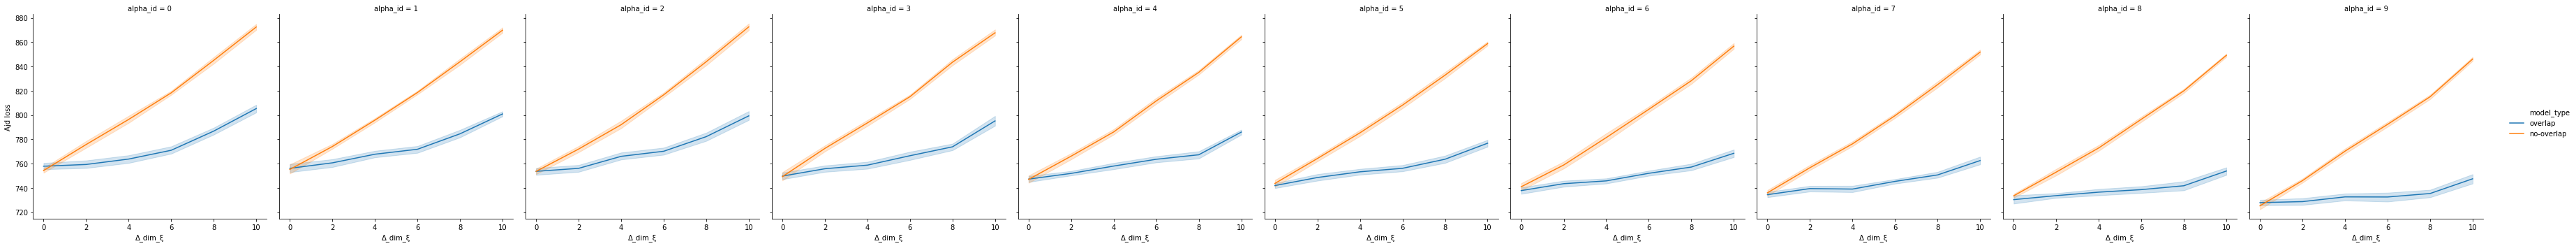

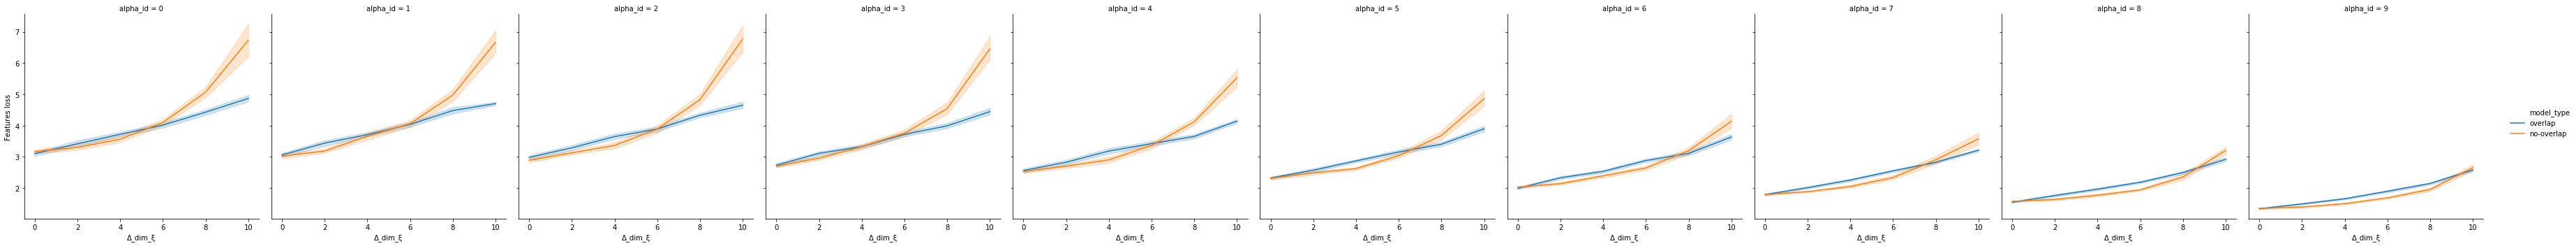

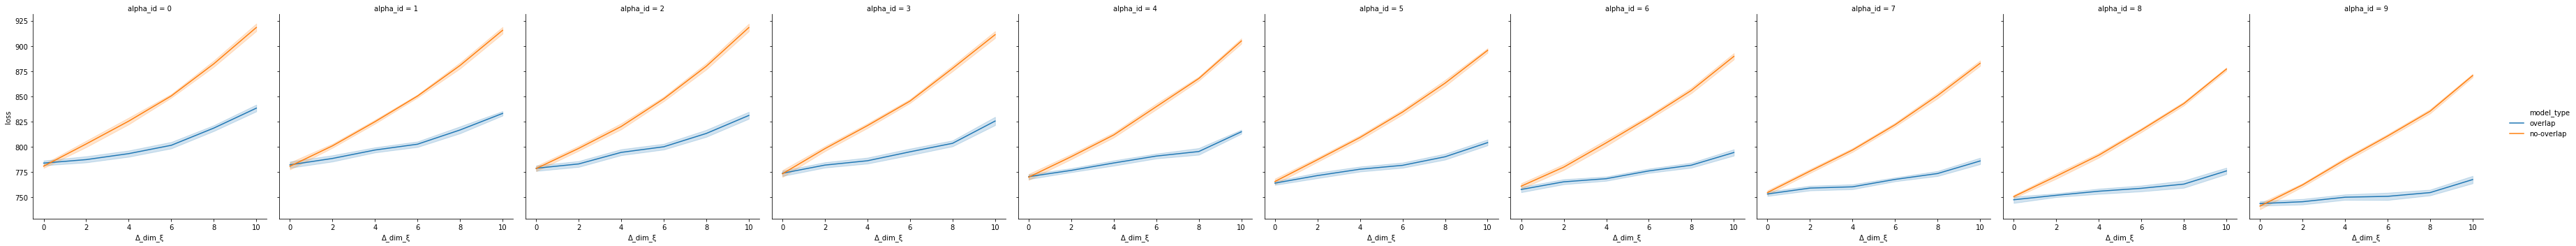

In [128]:
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'p_adj_loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Ajd loss')
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'p_v_loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Features loss')
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='loss')

Relative

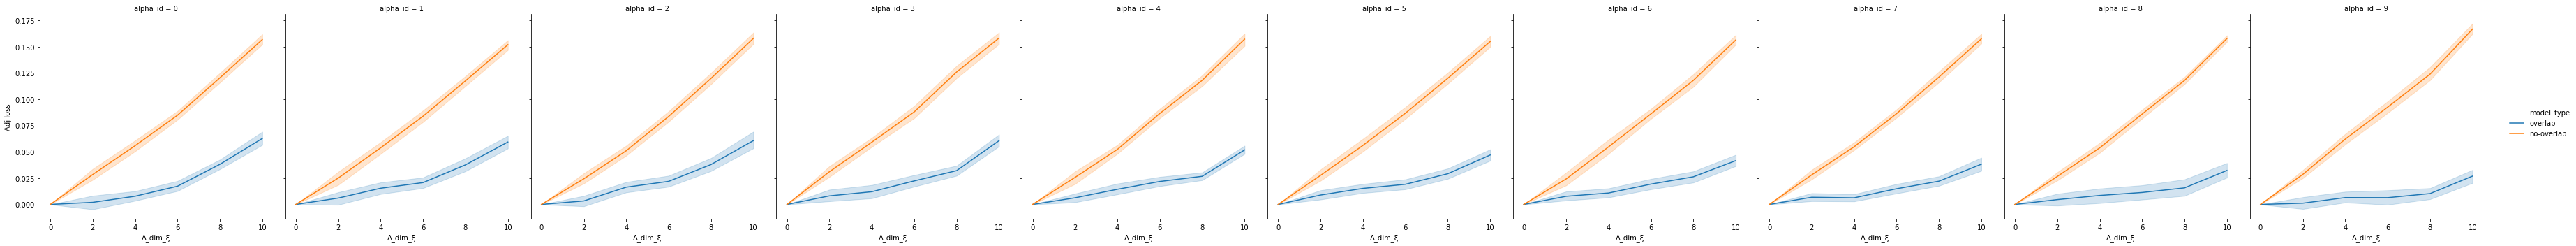

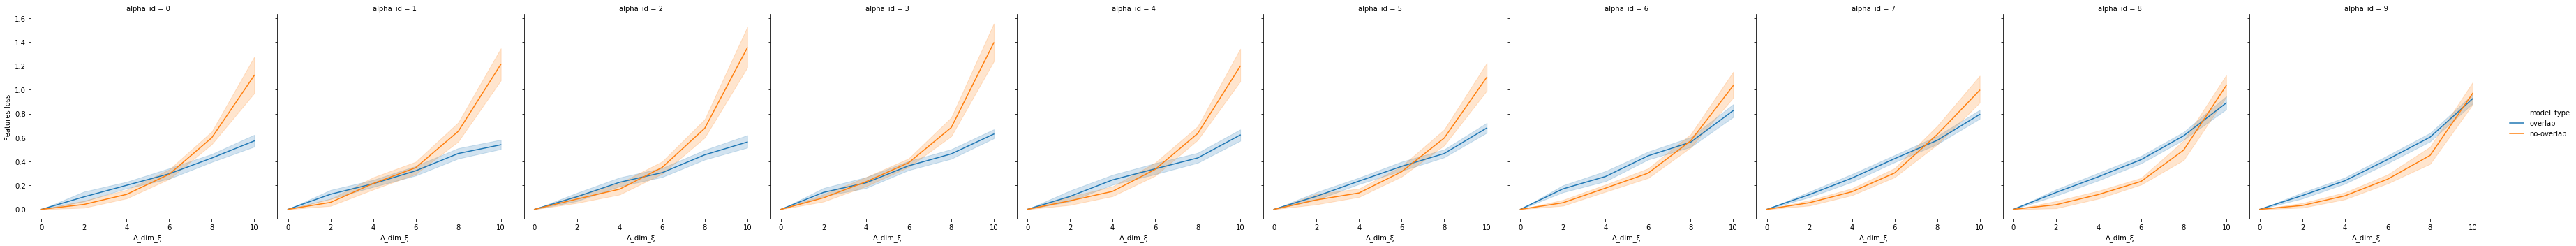

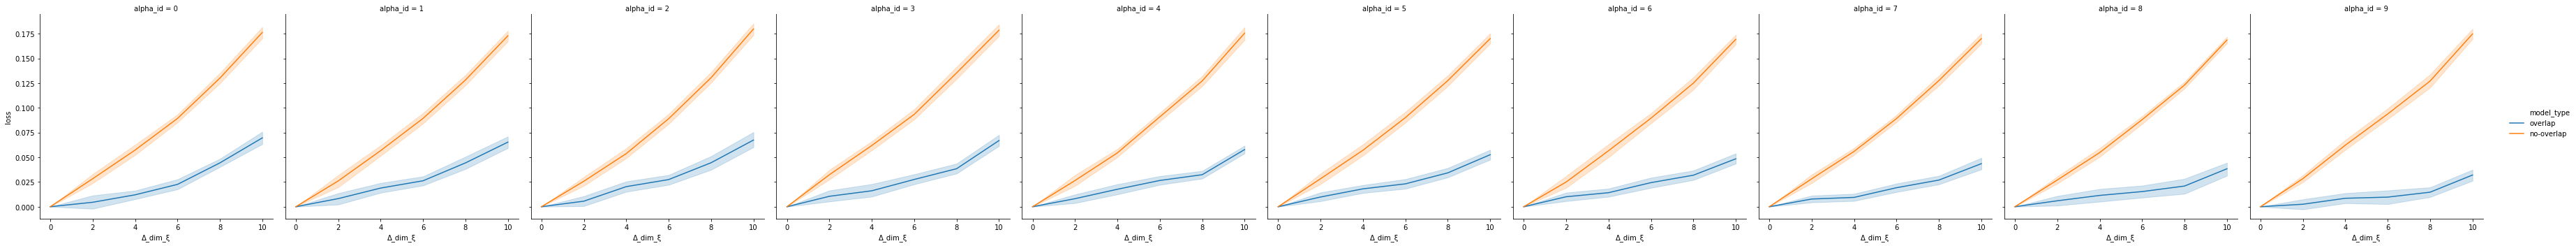

In [130]:
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'p_adj_loss')
                                                  & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Adj loss')
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'p_v_loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Features loss')
facet_grid = sb.relplot(x='Δ_dim_ξ', y='weighted best', col='alpha_id', hue='model_type',
                        hue_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='loss')

Absolute

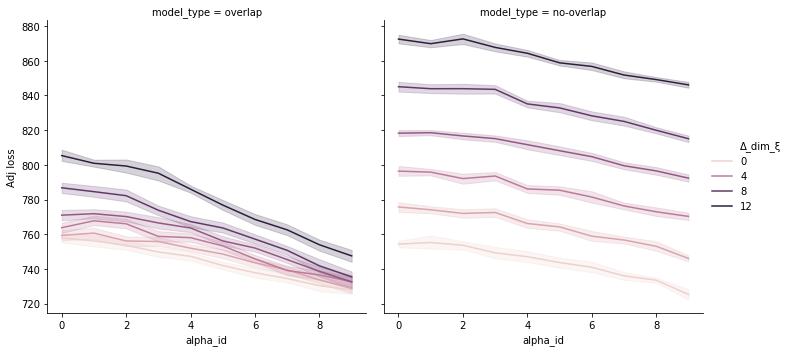

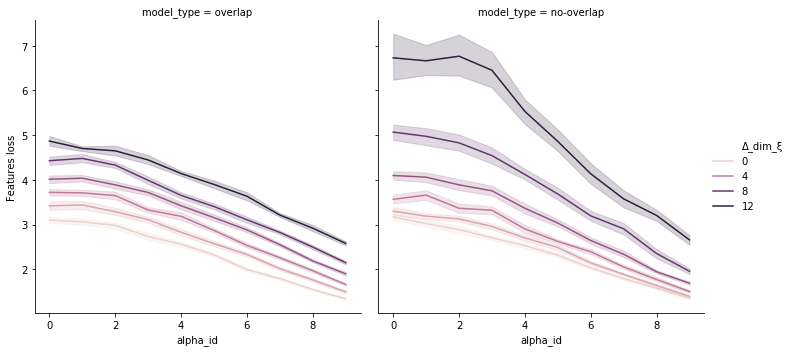

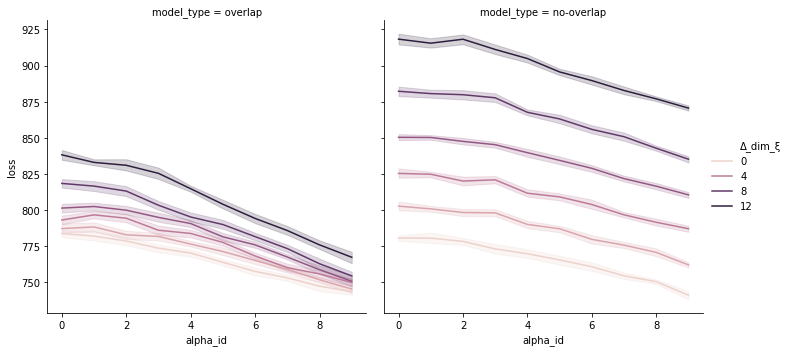

In [131]:
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'p_adj_loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Adj loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'p_v_loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Features loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results[(results.loss == 'loss')
                                     & (results.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='loss')

Relative

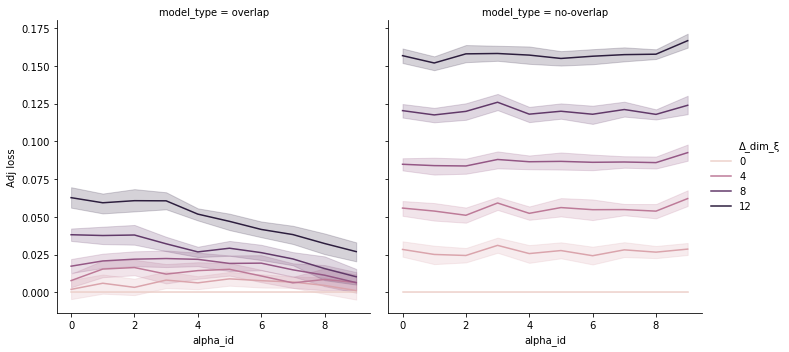

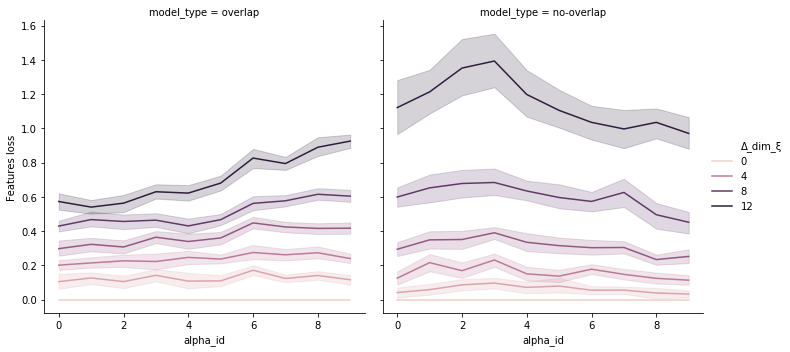

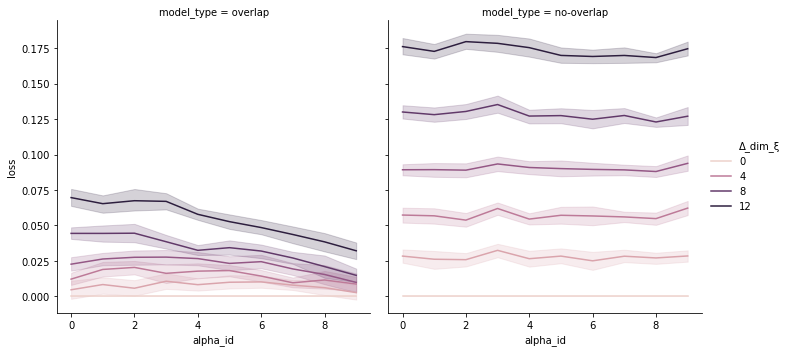

In [136]:
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'p_adj_loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Adj loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'p_v_loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='Features loss')
facet_grid = sb.relplot(x='alpha_id', y='weighted best',
                        hue='Δ_dim_ξ', col='model_type', col_order=['overlap', 'no-overlap'],
                        data=results_rel_Δ_dim_ξ[(results_rel_Δ_dim_ξ.loss == 'loss')
                                                 & (results_rel_Δ_dim_ξ.clustering_id == 1)],
                        kind='line')
facet_grid.set(ylabel='loss')

## Example results of a VAE

This is how you inspect one trained model (i.e. one dot in the scatter plots above).

In [ ]:
# Set the scenario, and reconstruct the model based on the trained weights.
aid = N_ALPHAS // 2
cid = 1
overlap = 0
sampling_id = 0
scenario = scenario_from_aid_cid(aid, cid)

q_model, q_codecs, vae = recover_model((aid, cid, overlap, sampling_id), trained_weights)
# Also get the corresponding loss history.
history = select((aid, cid, overlap, sampling_id), histories)
loss_weights = get_loss_weights(scenario[2].shape[0], scenario[3].shape[1], overlap)

Show the evolution of the losses.

In [ ]:
fig, axes = plt.subplots(1, len(history), figsize=(len(history) * 5, 4))
for i, (title, values) in enumerate(history.items()):
    axes[i].plot(np.array(values) * loss_weights.get(title[:-5], 1))
    axes[i].set_title(title)
fig.tight_layout()

Show the outputs of `q_model` and `vae`.

In [ ]:
plot_predictions(vae, scenario)

Plot kde estimates of the embeddings, projecting on all combinations of the different embedding dimensions. Colors correspond to STBM latest communities (Y in the paper).

In [ ]:
plot_ξ_distribution(q_model, q_codecs, scenario)

Finally, have a look at the weights in the different layers

In [ ]:
for layer in vae.layers:
    if hasattr(layer, 'kernel'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))#, sharey=True)
        im1 = ax1.imshow(K.eval(layer.kernel).T)
        ax1.set_title('{} kernel'.format(layer.name))
        plt.colorbar(im1, ax=ax1)
        if hasattr(layer, 'bias') and layer.bias is not None:
            im2 = ax2.imshow(K.eval(K.expand_dims(layer.bias, -1)))
            ax2.set_title('{} bias'.format(layer.name))
            plt.colorbar(im2, ax=ax2)
        else:
            ax2.set_visible(False)